Power consumed in the trip: 384.03 kwh
Trip distance: 35.76 km
Average speed for the trip: 44.21 km/hr
Required rating for Traction Motors: 305.90 kw


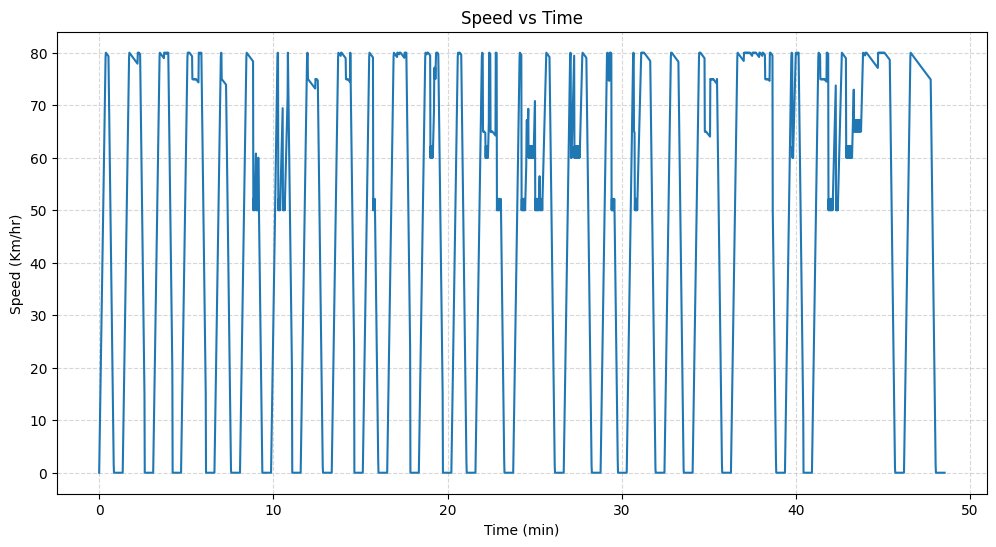

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os

from power_consumption_calculator import PowerConsumptionCalculator
from motor_rating_calculator import MotorRatingCalculator
from csv_loader import CSVLoader  # Import the new CSVLoader class
from train_simulation_report import TrainSimulationReport

class TrainSimulation:
    def __init__(self, 
                 train_params_dict:dict, 
                 stations:pd.core.frame.DataFrame, 
                 curves:pd.core.frame.DataFrame,
                 gradients:pd.core.frame.DataFrame, 
                 speed_restrictions:pd.core.frame.DataFrame,):

        self.train_params_dict = train_params_dict
        self.stations = stations
        self.curves = curves
        self.gradients = gradients
        self.speed_restrictions = speed_restrictions

        self.distance = 0
        self.time = 0
        self.speed = 0
        self.distance_log = [0]
        self.time_log = [0]
        self.speed_log = [0]
        self.segment_distance_log = [0]
        self.section_time_log = []
        self.section_avg_speed_log = []
        self.messages = []

        self.power_calculator = PowerConsumptionCalculator(
            float(train_params_dict['Train_mass']), 
            float(train_params_dict['Regeneration_efficiency'])
        )
        self.motor_rating_calculator = MotorRatingCalculator(train_params_dict)
        self.derived_values()

    # Derive the values from the passed arrays
    def derived_values(self):
        # Check coasting allowed
        self.no_coasting = False if train_params_dict['Coasting'] else True # Whether 'Coast' or not

        # Convert speeds from km/h to m/s
        self.max_speed = float(train_params_dict['Maximum_speed'])  * 1000 / 3600
        self.switch_speed = float(train_params_dict['Switch_speed'])  * 1000 / 3600

        # Extract the chainage and station names into list
        self.station_chainages = stations['Chainage'].values
        self.station_names = stations['Station_Name'].values

        # Distance calculations for controlling different run phase
        self.accelerating_distance = self.max_speed**2/2/float(train_params_dict['Acceleration_switch'])
        self.braking_distance = self.max_speed**2/2/float(train_params_dict['Braking_deceleration'])
        self.minm_run_distance = self.accelerating_distance + self.braking_distance

        # Frequently used variables
        self.train_mass = float(train_params_dict['Train_mass'])
        self.stop_duration = int(train_params_dict['Stop_duration'])
        self.acceleration = float(train_params_dict['Acceleration'])
        self.acceleration_switch = float(train_params_dict['Acceleration_switch'])
        self.switch_speed = float(train_params_dict['Switch_speed']) # Change acceleration here
        self.coasting_limit = float(train_params_dict['Coasting_limit']) # Speed limit for coasting period
        self.braking_deceleration = float(train_params_dict['Braking_deceleration'])
        
        # Create a dictionary to map radius to speed restriction
        self.speed_limit_dict = pd.Series(speed_restrictions.Speed_Limit.values, 
                                          index=speed_restrictions.Radius).to_dict()
        self.excel_paths()
        return 
    
    # Davis formula for resistance
    def davis(self, speed):
        static_friction = float(train_params_dict['Static_friction'])
        rolling_resistance = float(train_params_dict['Rolling_resistance'])
        air_resistance = float(train_params_dict['Air_resistance'])
        return (static_friction + rolling_resistance * speed + air_resistance * speed**2) * self.train_mass

    # Helper function to log time and speed
    def log_simulation_data(self):
        self.distance += self.speed
        self.distance_log.append(self.distance / 1000)  # Distance covered in km
        self.time_log.append(self.time / 60)  # Convert time to minutes for logging
        self.speed_log.append(self.speed * 18 / 5)  # Convert m/s to km/h for logging

    # The train accelerates with the passed on acceleration value.
    # Speed and time are incremented to their new values and stored
    def accelerate(self, acceleration, time_step=1):
        self.speed += acceleration * time_step 
        if self.speed > self.max_speed:
            self.speed = self.max_speed
        self.power_calculator.log_power_during_acceleration(self.speed, acceleration)
        self.time += time_step
        self.log_simulation_data()
        return
        
    # Coast if permitted, after reaching maximum speed. Friction will bring down the speed
    def coast(self, time_step=1):
        if (self.no_coasting): # Speed doesn't change
            self.time += time_step
            self.log_simulation_data()
            return
            
        # Convert mass from tons to kg (1 ton = 1000 kg)
        mass_kg = self.train_mass * 1000
    
        # Calculate the total resistance (Davis equation)
        resistance = self.davis(self.speed)
    
        # Calculate deceleration due to resistance (force/mass)
        deceleration = resistance / mass_kg  # in m/s²
    
        # Calculate the new speed after deceleration due to resistance
        self.speed -= deceleration * time_step if self.speed > 0 else 0
        self.time += time_step
        self.log_simulation_data()
        return

    # Function to find the speed restriction at a given distance
    def get_speed_restriction(self, time_step=1):
        for i in range(len(curves)):
            start = curves.iloc[i]['Start']
            end = curves.iloc[i]['End']
            radius = curves.iloc[i]['Radius']
            
            # Check if the current distance falls within the curve zone
            if start <= self.distance <= end:
                # Return the speed restriction for the corresponding radius
                self.speed = self.speed_limit_dict.get(radius)  * 1000 / 3600 
                self.time += time_step
                self.log_simulation_data()
        return 

    # Start braking before reaching the next station.
    def brake(self, time_step=1):
        self.speed -= self.braking_deceleration * time_step 
        if self.speed < 0:
            self.speed = 0
        self.power_calculator.log_power_during_braking(self.speed, self.braking_deceleration)
        self.time += time_step
        self.log_simulation_data()
        return

    # Train to accelerate after departure from station
    def accelerate_phase(self):
        while self.distance < self.cumulative_distance + self.accelerating_distance:
            # Acceleration rate changes at switch speed
            acceleration_loop = self.acceleration if self.speed < self.switch_speed else self.acceleration_switch
            self.accelerate(acceleration_loop, 1)
            if self.speed >= self.max_speed: # Stop acceleration if the maximum speed is reached
                break
        return
        
    # Function to handle coasting phase
    def coasting_phase(self):
        # Flag to indicate when we should continue accelerating to reach max speed
        should_accelerate = False
        while self.distance < (self.cumulative_distance + 
                               (self.segment_distance - self.braking_distance)): # Coast till braking distance to station
            if self.speed > self.coasting_limit * self.max_speed and not should_accelerate:
                self.coast(1)
            else:
                should_accelerate = True # Coasting limit has been reached, start accelerating
                self.accelerate(self.acceleration_switch, 1)
    
            if self.speed >= self.max_speed:
                self.speed = self.max_speed
                should_accelerate = False
            self.get_speed_restriction(1)
        return 

    # Function to handle braking phase
    def braking_phase(self):
        while self.distance < self.cumulative_distance + self.segment_distance:
            self.brake(1)
            if self.speed <= 0: # Train is at standstill
                break
        return 

    # Function to handle station stop phase
    def station_stop_phase(self):
        self.speed = 0
        for _ in range(self.stop_duration):
            self.time += 1
            self.log_simulation_data()
        return

    def train_trip(self):
        for i in range(len(self.station_names)-1):
            start_station = self.station_chainages[i]
            end_station = self.station_chainages[i+1]
            self.segment_distance = end_station - start_station
            self.cumulative_distance = sum(self.segment_distance_log)
            self.segment_distance_log.append(self.segment_distance)
           
            time_segment_start = self.time
        
            self.accelerate_phase()
            self.coasting_phase()
            self.braking_phase()
            self.station_stop_phase()
            time_segment_end = self.time
            self.section_time_log.append(time_segment_end - time_segment_start)
            self.section_avg_speed_log.append(self.segment_distance/(time_segment_end - time_segment_start) * 18/5)
            
            #print(f'section time:{self.section_time_log[-1]} s, Average Speed:{self.section_avg_speed_log[-1]:.2f} km/h')
            #print(f'Average speed:{self.segment_distance/(time_segment_end - time_segment_start) * 18/5}')

        self.messages.append(f'Power consumed in the trip: {self.power_calculator.calculate_energy_consumed():.2f} kwh')
        self.messages.append(f'Trip distance: {self.distance/1000:.2f} km')
        self.messages.append(f'Average speed for the trip: {self.distance/self.time*18/5:.2f} km/hr')
        self.messages.append(f'Required rating for Traction Motors: {self.motor_rating_calculator.display_motor_rating():.2f} kw')
        [print(msg) for msg in self.messages]
        return
        
    def print_values(self):
        return [type(self.station_chainages[1])]

    
    def run_simulation(self):
        # Implement the simulation logic here using the imported classes
        # Plot the speed vs time graph
        fig = plt.figure(figsize=(12, 6))
        
        plt.plot(self.time_log, self.speed_log)
        plt.title('Speed vs Time')
        plt.xlabel('Time (min)')
        plt.ylabel('Speed (Km/hr)')
        
        # Add grid lines for better readability
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.savefig(self.plot_path)
        #plt.show()
        
        self.excel_report()
        return

    def excel_paths(self):
        current_dir = os.getcwd()
        excel_dir = os.path.join(current_dir, "sheet")
        if not os.path.exists(excel_dir):
            os.makedirs(excel_dir)
        self.excel_path = os.path.join(excel_dir, "output.xlsx")
        self.plot_path = os.path.join(excel_dir, "plot.png")
        return
        
    def excel_report(self):
        df_speed = pd.DataFrame({
            "Time":self.time_log,
            "Speed":self.speed_log
            })

        tsr = TrainSimulationReport(self.excel_path, self.plot_path, df_speed, 
                                    self.station_names,self.segment_distance_log, 
                                    self.section_avg_speed_log, self.messages)
        tsr.generate_spreadsheet()
        return

if __name__ == "__main__":
    # Initialize the CSV loader
    csv_loader = CSVLoader()

    # List of CSV files and their labels
    csv_files = [
        ('train_parameters.csv', 'train_params'),
        ('stations.csv', 'stations'),
        ('curves.csv', 'curves'),
        ('gradients.csv', 'gradients'),
        ('sr.csv', 'speed_restrictions')
    ]
    
    # Load data from CSV files
    data_dict = csv_loader.load_csv_list(csv_files)

    # Access the loaded data
    train_params_dict = data_dict['train_params']
    stations = data_dict['stations']
    curves = data_dict['curves']
    gradients = data_dict['gradients']
    speed_restrictions = data_dict['speed_restrictions']

    # Initialize the TrainSimulation class with parameters from the CSV
    simulation = TrainSimulation(train_params_dict, stations, curves, gradients, speed_restrictions)
    simulation.train_trip()
    
    #print(simulation.print_values())

    # Run the simulation
    simulation.run_simulation()


In [2]:
print(float(train_params_dict['Acceleration']))

1.0
